In [ ]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1

downgrading tensorflow
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
     |████████████████████████████████| 460kB 42.7MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
downgrading keras
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 5.5MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 


In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from tqdm import tqdm_notebook as tqdm
from time import time
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold, KFold

try:
    import dill as pickle
except ImportError:
    import pickle

Using TensorFlow backend.


In [ ]:
try:
    import dill as pickle
except ImportError:
    import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

base_dir = "/content/drive/My Drive/MB/"
dataset_dir = "/content/drive/My Drive/"
descriptions_filename = dataset_dir + "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
descriptions_doc = load_doc(descriptions_filename)
print(descriptions_doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        if len(line) < 2:
            continue
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(descriptions_doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.items())[:1]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .'])]

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')

def clean_descriptions(descriptions):
    
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            # create tokens from sentence
            desc = tokenizer.tokenize(desc)
            
            # make tokens lowercase
            desc = [word.lower() for word in desc]
            
            # filter one letter tokens
            desc = [word for word in desc if len(word)>1]

            # filter stop words ('or', 'because', 'as', ...)
            # stop_words = set(stopwords.words('english'))
            # desc = [word for word in desc if not word in stop_words]
            
            # stem words (remove endings like -ing, -s)
            # porter = PorterStemmer()
            # desc = [porter.stem(word) for word in desc]
            
            # merge into one string
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
descriptions['1000268201_693b08cb0e']

# def bag_of_words()

# dla id = 1000268201_693b08cb0e
# wybieramy unikalnie wyrazy z descriptions['1000268201_693b08cb0e']
# z naszego wygenerowanego zdania, sprawdzamy po kolei wyraz. Jeśli jest w powyższym zbiorze, dodajemy counter
# counter podzielić przez ilość wyrazów w wygenerowanym zdaniu - wynik

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def getVocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = getVocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8464


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, base_dir + 'descriptions.txt')
print("Desciption.txt created")

Desciption.txt created


In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_names = load_set(filename)
print('Train size: %d' % len(train_names))

Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 6000


In [ ]:
# Loading test data, 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.testImages.txt'
test_names = load_set(filename)
print('Test Size: %d' % len(test_names))

Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 1000


In [ ]:
# we r extracting train data captions such that, each captions starts with 'startseq' and ends with 'endseq
def load_clean_descriptions(filename, dataset):
    # load document
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', train_names)

print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
test_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', test_names)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [ ]:
# Save train_descriptions
with open(base_dir + "train_descriptions.pkl", "wb") as encoded_pickle:
    pickle.dump(train_descriptions, encoded_pickle)

In [ ]:
# Save test_descriptions
with open(base_dir + "test_descriptions.pkl", "wb") as encoded_pickle:
    pickle.dump(test_descriptions, encoded_pickle)

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


In [ ]:
# model.summary()

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    v = model_new.predict(image) 
    v = np.reshape(v, v.shape[1]) 
    return v

In [ ]:
# # Encoding all the Training Dataset to a 2048 Dimension Vectors, Run this once
# start = time()
# k=0
# encoded_train = {}
# for img in tqdm(train_img):
 
#     encoded_train[img[len(Directroy_path):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [ ]:
# # Encoding all the Test Dataset to a 2048 Dimension Vectors, Run this once
# start = time()
# encoded_test = {}
# for img in tqdm(test_img):
#     encoded_test[img[len(Directroy_path):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [ ]:
# # Save Train features
# with open(base_dir + "encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoded_train, encoded_pickle)

In [ ]:
# # Save test features 

# from pickle import dump, load
# with open(base_dir + "encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoded_test, encoded_pickle)

In [ ]:
# train_img[0][len(Directroy_path):]

In [ ]:
# len(encoded_train)

In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Loading Image Features
test_features = load(open(base_dir + "encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(test_features))

Photos: train=1000


In [ ]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [ ]:
# Create a list of all the training captions
train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        train_captions.append(cap)
len(train_captions)

30000

In [ ]:
threshold = 7
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        if w not in word_counts:
            word_counts[w] = 0
        word_counts[w] += 1

vocab = [w for w in word_counts if word_counts[w] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7350 -> 2063


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions): 
    max_l = -1e9
    for key, cap in descriptions.items():
        for line in cap:
            max_l = max(max_l, len(line.split(' ')))
    return max_l

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 35


In [ ]:
# Load Glove vectors, which contains vectors(200 Dimension) corresponding to words. 
glove_dir = '/content/drive/My Drive/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'Kopia glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Found 400000 word vectors.


In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoix.items()):
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
embedding_matrix.shape # (vocab, embedding_dim)

(2064, 200)

In [ ]:
with open(base_dir + 'Embedding_Matrix.pkl', 'wb') as embedding_pickle:
    pickle.dump(embedding_matrix, embedding_pickle)

In [ ]:
with open(base_dir + 'wordtoix.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [ ]:
# Loading embedding_matrix
embedding_matrix = load(open(base_dir + "Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (2064, 200)


In [ ]:
# Loading wordtoix
wordtoix = load(open(base_dir + "wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [ ]:
max_length = 34 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(keys, descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for idx, (key, desc_list) in enumerate(descriptions.items()):
            if idx not in keys:
              continue
            n+=1
            
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y

In [ ]:
train_features['2513260012_03d33305cf.jpg'].shape

(2048,)

In [ ]:
max_length = 35 
vocab_size = embedding_matrix.shape[0]
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

max_length,vocab_size

(35, 2064)

In [ ]:
def createModel(max_length, vocab_size, embedding_matrix):
  embedding_dim = embedding_matrix.shape[1]

  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  my_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  my_model.layers[2].set_weights([embedding_matrix])
  my_model.layers[2].trainable = False
  my_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
  return my_model


In [ ]:
my_model = createModel(max_length, vocab_size, embedding_matrix)
my_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      412800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
starting_epoch = 0
if starting_epoch > 0:
  my_model = load_model(base_dir + 'model_' + str(starting_epoch-1) + '.h5')
epochs = 20
number_pics_per_bath = 5
train_steps = len(train_descriptions)//number_pics_per_bath
test_steps = len(test_descriptions)//number_pics_per_bath

In [ ]:
# # error to stop

# histories = []
# # kfold = StratifiedKFold(5, True, 1)
# n = 5
# kfold = KFold(n, shuffle=True)

# all_descriptions = {**train_descriptions, **test_descriptions}
# all_features = {**train_features, **test_features}

# k = np.array(list(all_descriptions.keys()))
# i = 0
# for train, test in kfold.split(k):
#   i += 1
#   filepath = "fold" + str(i) + "_model_{epoch:02d}.h5"
#   print(train[0])
#   checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
#   train_generator = data_generator(train, all_descriptions, all_features, wordtoix, max_length, number_pics_per_bath)
#   test_generator = data_generator(test, all_descriptions, all_features, wordtoix, max_length, number_pics_per_bath)

#   history = my_model.fit_generator(train_generator, 
#                          epochs=epochs, 
#                          steps_per_epoch=train_steps, 
#                          verbose=1, 
#                          validation_steps=test_steps,
#                          validation_data=test_generator,
#                          callbacks=[checkpoint])
#   histories.append(history.history)
# with open(base_dir + 'training_histories.pkl', 'wb') as history_pickle:
#     pickle.dump(histories, history_pickle)

0
Epoch 1/20
1200/1200 [==============================] - 225s 187ms/step - loss: 3.5381 - val_loss: 2.9452

Epoch 00001: saving model to fold1_model_01.h5
Epoch 2/20
1200/1200 [==============================] - 227s 189ms/step - loss: 3.2877 - val_loss: 3.2195

Epoch 00002: saving model to fold1_model_02.h5
Epoch 3/20
1200/1200 [==============================] - 227s 189ms/step - loss: 3.1214 - val_loss: 3.2759

Epoch 00003: saving model to fold1_model_03.h5
Epoch 4/20
1200/1200 [==============================] - 226s 188ms/step - loss: 3.0086 - val_loss: 3.5794

Epoch 00004: saving model to fold1_model_04.h5
Epoch 5/20
1200/1200 [==============================] - 226s 189ms/step - loss: 2.9194 - val_loss: 4.2244

Epoch 00005: saving model to fold1_model_05.h5
Epoch 6/20
1200/1200 [==============================] - 225s 188ms/step - loss: 2.8509 - val_loss: 2.6830

Epoch 00006: saving model to fold1_model_06.h5
Epoch 7/20
1200/1200 [==============================] - 224s 187ms/step - 

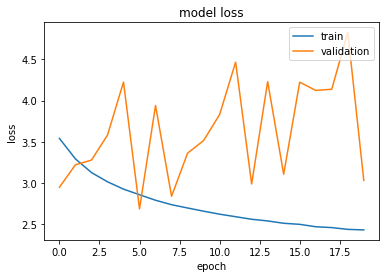

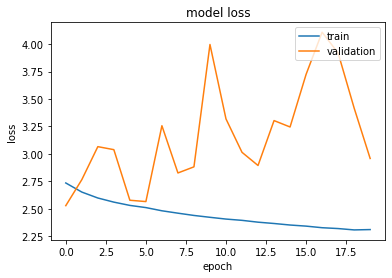

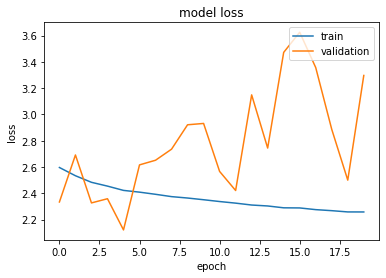

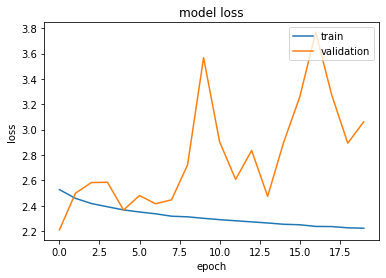

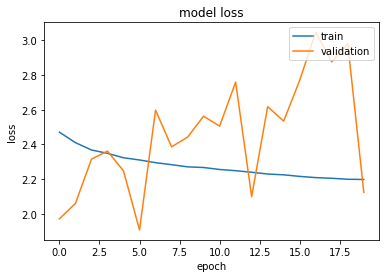

In [ ]:
for history in histories:
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

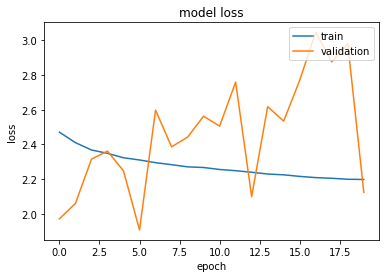

In [ ]:
histories
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
